# Hotel Recommendation System using Keras

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras import backend as K

from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
hotel_train_data = pd.read_csv("/Users/lufthikautsar/Downloads/Hotel_Recomendation_Model_Traveloka/Eksplorasi Data/goiboi+datafiniti_merge_user-collaborative-based.csv", sep=',')

In [4]:
hotel_train_data.head(2)

,property_id,user_id,user_rating,user_reviews,property_name,hotel_description,address,point_of_interest,city,state,...,Two Line Telephone,Utensils (on request),Video/ DVD/ CD Player Available,Voicemail.1,Wardrobe,Washing machine,Western Toilet Seat,Window Opens,Work Station,Working Desk Phone
0,H000001,0,4,Staff were helpful and friendly. Wireless inte...,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0
1,H000001,6853,2,Service was fine but the hotel was worn down: ...,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0


# Data Pre-processing

In [5]:
df = hotel_train_data[['user_id','property_id','user_rating']]

In [6]:
#For collaborative, we'll use ratings
df.columns =['User_id', 'Item_id', 'Rating']
df.head()

,User_id,Item_id,Rating
0,0,H000001,4
1,6853,H000001,2
2,4632,H000001,4
3,8325,H000001,4
4,2065,H000002,4


In [7]:
df.shape

(9748, 3)

In [8]:
n_users = len(df.User_id.unique())
n_users

9222

In [9]:
n_hotels = len(df.Item_id.unique())
n_hotels

1433

Create variables with the total number of unique users and item in the data, as well as the min and max ratings present in the data

In [10]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['User_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['Item_id'].values)
n_items = df['item'].nunique()

df['rating'] = df['Rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])
n_users, n_items
print(min_rating, max_rating)

1.0 5.0


# Split the data into training and test data sets

In [11]:
X = df[['user', 'item']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7798, 2), (1950, 2), (7798,), (1950,))

In [39]:
print(df['user'])

0          0
1       6853
2       4632
3       8325
4       2065
        ... 
9743    9093
9744    9099
9745    9127
9746    9170
9747    9194
Name: user, Length: 9748, dtype: int64


In [40]:
print(df['item'])

0          0
1          0
2          0
3          0
4          1
        ... 
9743    1428
9744    1429
9745    1430
9746    1431
9747    1432
Name: item, Length: 9748, dtype: int64


In [17]:
n_factors = 240
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [18]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
    
# add fully-connected-layers
fc1 = Dense(512, activation='relu')(x)
fc2 = tf.keras.layers.Dropout(0.2)(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 240)       2213280     ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 240)       343920      ['input_6[0][0]']                
                                                                                            

In [20]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=30,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/30
122/122 [==============================] - 14s 87ms/step - loss: 4.0604 - accuracy: 0.0000e+00 - val_loss: 4.0536 - val_accuracy: 0.0000e+00
Epoch 2/30
122/122 [==============================] - 10s 80ms/step - loss: 4.0256 - accuracy: 0.0000e+00 - val_loss: 4.0190 - val_accuracy: 0.0000e+00
Epoch 3/30
122/122 [==============================] - 10s 81ms/step - loss: 3.9902 - accuracy: 0.0000e+00 - val_loss: 3.9838 - val_accuracy: 0.0000e+00
Epoch 4/30
122/122 [==============================] - 10s 82ms/step - loss: 3.9543 - accuracy: 0.0000e+00 - val_loss: 3.9479 - val_accuracy: 0.0000e+00
Epoch 5/30
122/122 [==============================] - 10s 80ms/step - loss: 3.9176 - accuracy: 0.0000e+00 - val_loss: 3.9109 - val_accuracy: 0.0000e+00
Epoch 6/30
122/122 [==============================] - 10s 80ms/step - loss: 3.8797 - accuracy: 0.0000e+00 - val_loss: 3.8723 - val_accuracy: 0.0000e+00
Epoch 7/30
122/122 [==============================] - 10s 81ms/step - loss: 3.8399 - acc

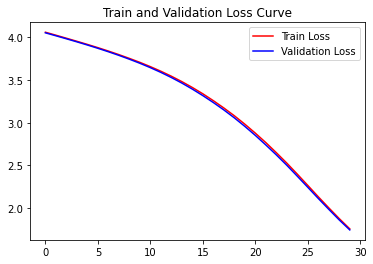

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

## Creating RMSE function for Neural Network

In [23]:
def root_mean_squared_error(y_test, y_train):
        return K.sqrt(K.mean(K.square(y_test - y_train))) 

In [24]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
     
# add fully-connected-layers
fc1 = Dense(512, activation='relu')(x)
fc2 = tf.keras.layers.Dropout(0.2)(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer = opt , loss = root_mean_squared_error, metrics=['accuracy'])

In [25]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 240)       2213280     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 240)       343920      ['input_8[0][0]']                
                                                                                            

In [26]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=30,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/30
122/122 [==============================] - 12s 84ms/step - loss: 4.2298 - accuracy: 0.0000e+00 - val_loss: 4.2249 - val_accuracy: 0.0000e+00
Epoch 2/30
122/122 [==============================] - 10s 79ms/step - loss: 4.1968 - accuracy: 0.0000e+00 - val_loss: 4.1922 - val_accuracy: 0.0000e+00
Epoch 3/30
122/122 [==============================] - 10s 80ms/step - loss: 4.1631 - accuracy: 0.0000e+00 - val_loss: 4.1592 - val_accuracy: 0.0000e+00
Epoch 4/30
122/122 [==============================] - 10s 83ms/step - loss: 4.1298 - accuracy: 0.0000e+00 - val_loss: 4.1255 - val_accuracy: 0.0000e+00
Epoch 5/30
122/122 [==============================] - 10s 81ms/step - loss: 4.0953 - accuracy: 0.0000e+00 - val_loss: 4.0911 - val_accuracy: 0.0000e+00
Epoch 6/30
122/122 [==============================] - 10s 82ms/step - loss: 4.0600 - accuracy: 0.0000e+00 - val_loss: 4.0556 - val_accuracy: 0.0000e+00
Epoch 7/30
122/122 [==============================] - 11s 88ms/step - loss: 4.0239 - acc

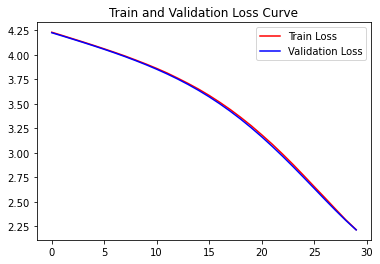

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

# Making Recommendations

In [74]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array([0, 1, 2, 3, 4])

In [75]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [76]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

array([72, 49, 59, 19, 36], dtype=int64)

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92


In [41]:
hotel_data = np.array(list(set(df['item'])))
hotel_data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
id_user = 20
user = np.array([id_user for i in range (len(hotel_data))])
user[:10]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [43]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()[:10]
recommended_hotel_id

45/45 [==============================] - 0s 5ms/step


array([  6,  83, 138,  21,  84,   4,  62, 115,  77,  34])

In [44]:
predictions[recommended_hotel_id]

array([4.595995 , 4.157644 , 3.9491413, 3.9372382, 3.914852 , 3.8839493,
       3.7683673, 3.7665148, 3.7572596, 3.6514044], dtype=float32)